<h1><center>Прогнозирование заказов такси</center></h1>

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

**Цель работы** - спрогнозировать кол-во заказов такси на следующий час. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Ход работы**
1. [Подготовка данных](#Подготовка-данных)
2. [Исследовательский анализ](#Исследовательский-анализ)
3. [Построение моделей](#Построение-моделей)
4. [Тестирование](#Тестирование)
5. [Общий вывод](#Общий-вывод)

## Подготовка данных

### Импорт модулей

In [1]:
RANDOM_STATE = 2023

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

<font size='4'>**Знакомство с данными + предобработка**</font>

In [3]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv(r'C:\Users\dcba5\Documents\Jupyter Data\taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
data.index = pd.to_datetime(data.index)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [7]:
# проверка упорядоченности временного ряда

data.index.is_monotonic

True

In [8]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Пропусков в данных нет, дубликаты не проверяются (столбец со временем выбран как индекс, а кол-во заказов в реальности может дублироваться). Временная последовательность упорядочена.

## Исследовательский анализ

In [9]:
# по условию мы должны провести ресемплинг ряда с промежутком в один час

data_resampled = data.resample('1H').sum()

In [10]:
decomposed = seasonal_decompose(data_resampled)

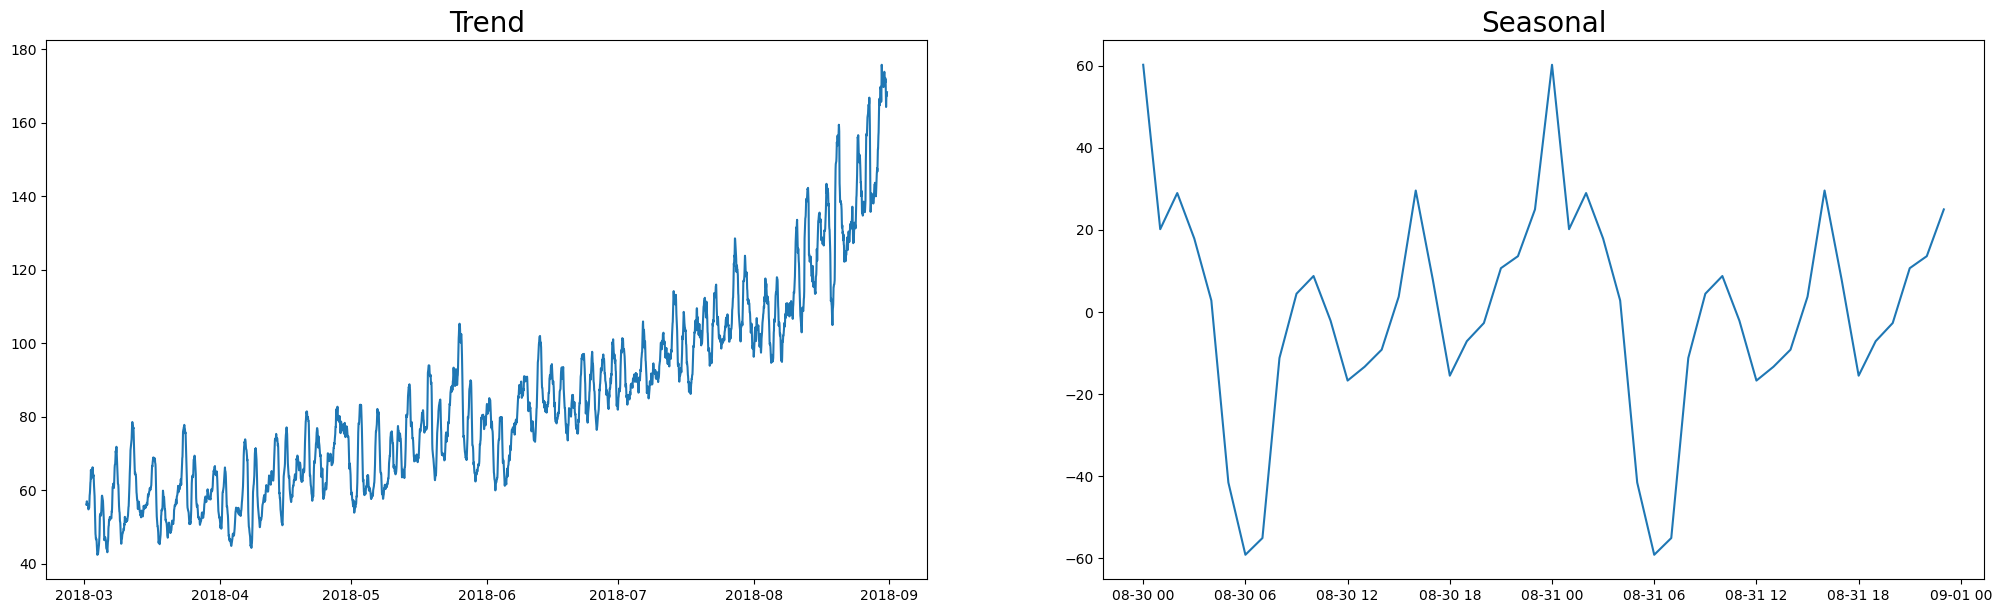

In [11]:
plt.figure(figsize=(25, 7))

plt.subplot(1, 2, 1)
plt.title('Trend', fontsize=20)
plt.plot(decomposed.trend)

plt.subplot(1, 2, 2)
plt.title('Seasonal', fontsize=20)
plt.plot(decomposed.seasonal['2018-08-30': '2018-08-31'])

plt.show()

Количество заказов растёт с марта по август 2018 года. Спрос на такси в конце августа в расчёте на один день возрастает с 6 утра до полуночи.

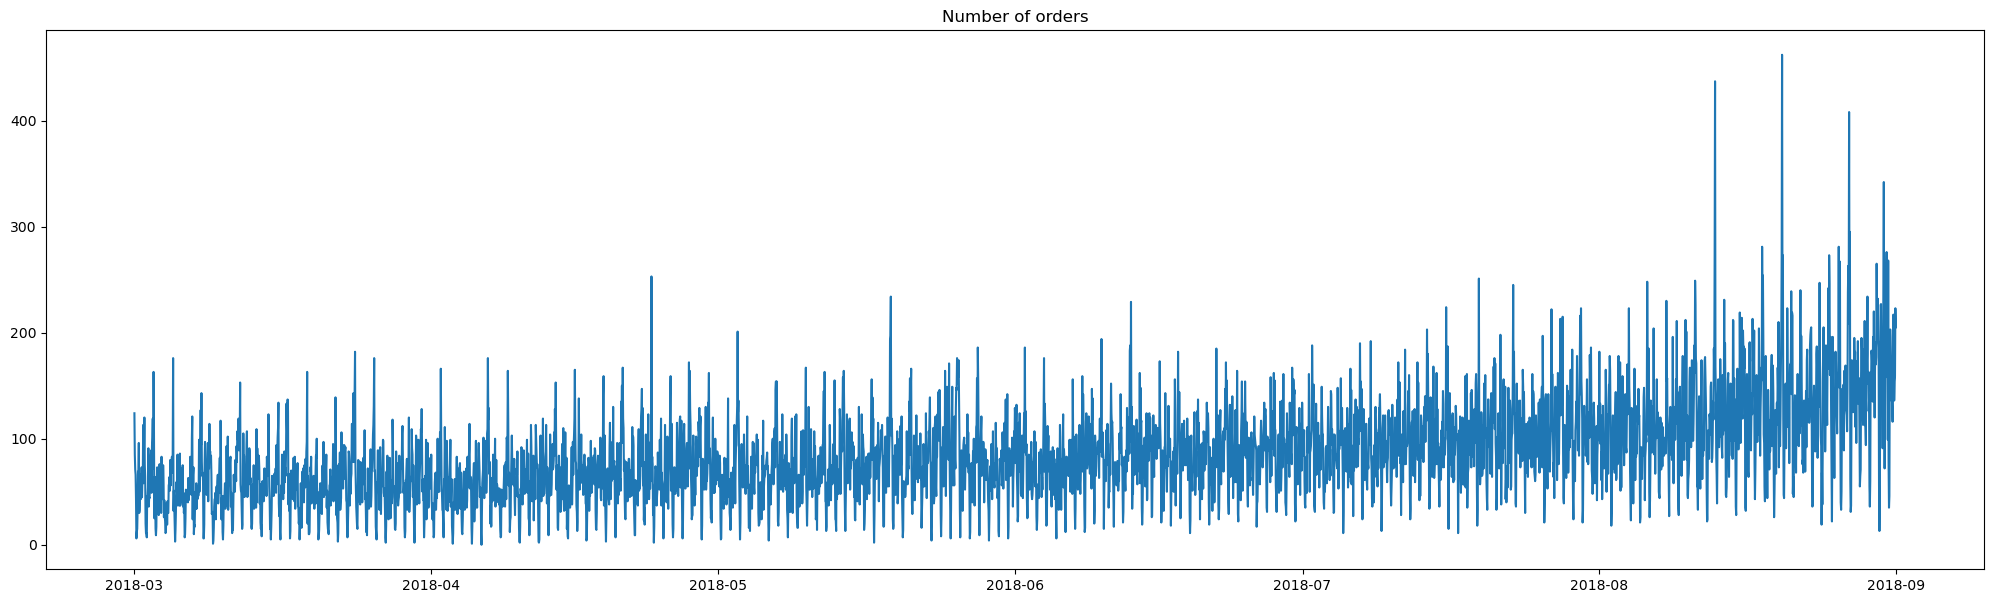

In [12]:
# строим график

plt.figure(figsize=(25, 7))
plt.plot(data_resampled)
plt.title('Number of orders')
plt.show()

График очень шумный. Для избавления от шумов выполним сглаживание методом скользящего окна.

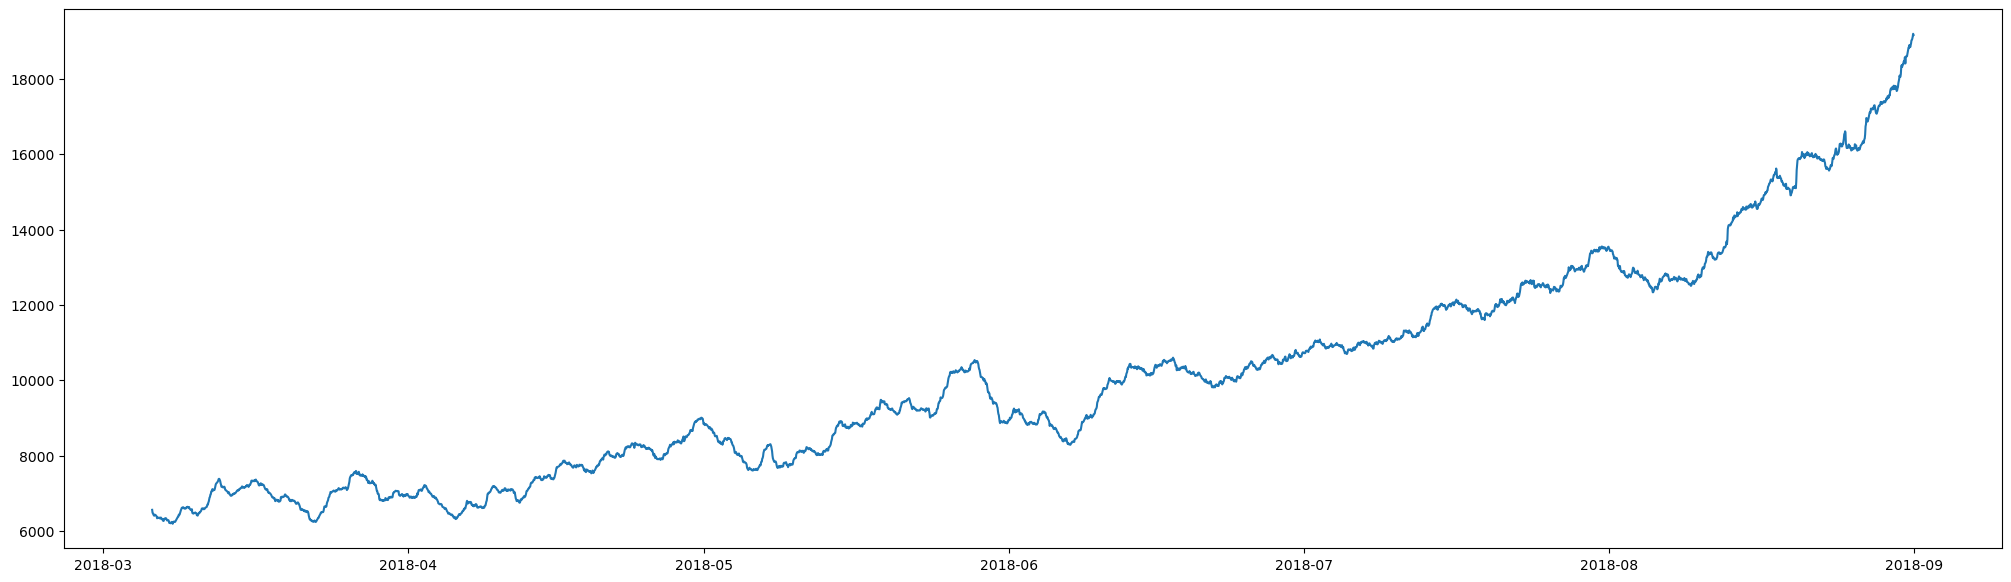

In [13]:
plt.figure(figsize=(25, 7))
plt.plot(data_resampled.rolling(120).sum())

Приступим к тестированию моделей.

## Построение моделей

### Подготовка выборок

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    '''
    Функция для создания признаков
    '''
    data_new = data.copy()
    data_new['year'] = data_new.index.year
    data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek  
    data_new['hour'] = data_new.index.hour
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_new


def make_data(data):
    '''
    Функция для создания выборок
    '''
    testing_data = data.copy()
    testing_data.dropna(inplace=True, axis=0)
    # testing_data.reset_index(drop=True, inplace=True)
    
    train, test = train_test_split(testing_data, shuffle=False, test_size=0.1)
    
    x_train = train.drop('num_orders', axis=1)
    y_train = train['num_orders']
    x_test = test.drop('num_orders', axis=1)
    y_test = test['num_orders']
    
    return x_train, y_train, x_test, y_test, testing_data

In [15]:
validation_data = make_features(data_resampled, 3, 10)

In [16]:
x_train, y_train, x_test, y_test, _ = make_data(validation_data)

In [17]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3965, 9)
(3965,)
(441, 9)
(441,)


### Обучение моделей

In [18]:
# объект для выделения подвыборок во временных рядах

tscv = TimeSeriesSplit(n_splits=5)

**Линейная регрессия**

In [19]:
linreg = LinearRegression()

In [20]:
# параметры для перебора

params = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

In [21]:
linreg_grid = GridSearchCV(linreg, 
                           param_grid=params, 
                           n_jobs=-1, 
                           scoring='neg_root_mean_squared_error', 
                           cv=tscv)

In [22]:
linreg_grid.fit(x_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'positive': [True, False]},
             scoring='neg_root_mean_squared_error')

In [23]:
# датафрейм с результатами оптимизатора
linreg_grid_results = pd.DataFrame(linreg_grid.cv_results_)[['mean_fit_time', 'mean_score_time', 'rank_test_score']]

# время обучения и предсказания
linreg_fit = linreg_grid_results.loc[linreg_grid_results['rank_test_score'] == 1, 'mean_fit_time']
linreg_pred = linreg_grid_results.loc[linreg_grid_results['rank_test_score'] == 1, 'mean_score_time']

print(f'''Best RMSE: {-1 * linreg_grid.best_score_:.2f}
Fit time: {linreg_fit.values[0]:.2f}
Prediction time: {linreg_pred.values[0]:.2f}''')

Best RMSE: 31.45
Fit time: 0.00
Prediction time: 0.00


**Дерево решений**

In [24]:
tree = DecisionTreeRegressor(random_state=RANDOM_STATE)

In [25]:
params = {
    'max_depth': range(5, 21),
    'min_samples_split': range(2, 6),
    'min_samples_leaf': range(1, 5),
}

In [26]:
tree_grid = GridSearchCV(tree, 
                         param_grid=params, 
                         n_jobs=-1, 
                         scoring='neg_root_mean_squared_error', 
                         cv=tscv)

In [27]:
tree_grid.fit(x_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(random_state=2023), n_jobs=-1,
             param_grid={'max_depth': range(5, 21),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 6)},
             scoring='neg_root_mean_squared_error')

In [28]:
# датафрейм с результатами оптимизатора
tree_grid_results = pd.DataFrame(tree_grid.cv_results_)[['mean_fit_time', 'mean_score_time', 'rank_test_score']]

# время обучения и предсказания
tree_fit = tree_grid_results.loc[tree_grid_results['rank_test_score'] == 1, 'mean_fit_time']
tree_pred = tree_grid_results.loc[tree_grid_results['rank_test_score'] == 1, 'mean_score_time']

print(f'''Best RMSE: {-1 * tree_grid.best_score_:.2f}
Fit time: {tree_fit.values[0]:.2f}
Prediction time: {tree_pred.values[0]:.2f}''')

Best RMSE: 28.21
Fit time: 0.01
Prediction time: 0.00


**Градиентный бустинг LightGBM**

In [29]:
lgbm = LGBMRegressor(random_state=RANDOM_STATE)

In [30]:
params = {
    'n_estimators': [1000, 2000,  500],
    'reg_lambda': np.arange(0.1, 0.3, 0.1),
    'learning_rate': np.arange(0.05, 0.4, 0.05)
}

In [31]:
lgbm_grid = GridSearchCV(lgbm, 
                         param_grid=params, 
                         n_jobs=-1, 
                         scoring='neg_root_mean_squared_error',
                         error_score='raise',
                         cv=tscv)

In [32]:
lgbm_grid.fit(x_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             error_score='raise', estimator=LGBMRegressor(random_state=2023),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]),
                         'n_estimators': [1000, 2000, 500],
                         'reg_lambda': array([0.1, 0.2])},
             scoring='neg_root_mean_squared_error')

In [33]:
# датафрей с результатами оптимизатора
lgbm_grid_results = pd.DataFrame(lgbm_grid.cv_results_)[['mean_fit_time', 'mean_score_time', 'rank_test_score']]

# время обучения и предсказания
lgbm_fit = lgbm_grid_results.loc[lgbm_grid_results['rank_test_score'] == 1, 'mean_fit_time']
lgbm_pred = lgbm_grid_results.loc[lgbm_grid_results['rank_test_score'] == 1, 'mean_score_time']

print(f'''Best RMSE: {-1 * lgbm_grid.best_score_:.2f}
Fit time: {lgbm_fit.values[0]:.2f}
Prediction time: {lgbm_pred.values[0]:.2f}''')

Best RMSE: 26.16
Fit time: 0.35
Prediction time: 0.03


**Вывод**: для решения нашей задачи подходят две модели: дерево и бустинг. Они имеют несущественные различия необходимой нам метрики, но бустинг, выигрывая в **RMSE**, работает медленнее. Однако для дальнейшего исследования я остановлюсь на **LGBM**.

In [34]:
best_lgbm = lgbm_grid.best_estimator_

## Тестирование

In [35]:
testing_data = make_features(data=data_resampled, max_lag=180, rolling_mean_size=20)

In [36]:
x_train, y_train, x_test, y_test, to_visualize = make_data(testing_data)

In [37]:
best_lgbm.fit(x_train, y_train)

LGBMRegressor(learning_rate=0.05, n_estimators=500, random_state=2023,
              reg_lambda=0.1)

In [38]:
print(f'Final RMSE of LightGBM = {mean_squared_error(best_lgbm.predict(x_test), y_test) ** 0.5:.2f}')

Final RMSE of LightGBM = 36.63


In [39]:
final_columns = {'True data': y_test, 'Predicted data': best_lgbm.predict(x_test)}

In [40]:
final_data = pd.DataFrame(final_columns, index=x_test.index)

In [41]:
final_data_roolling = final_data.rolling(100).mean()

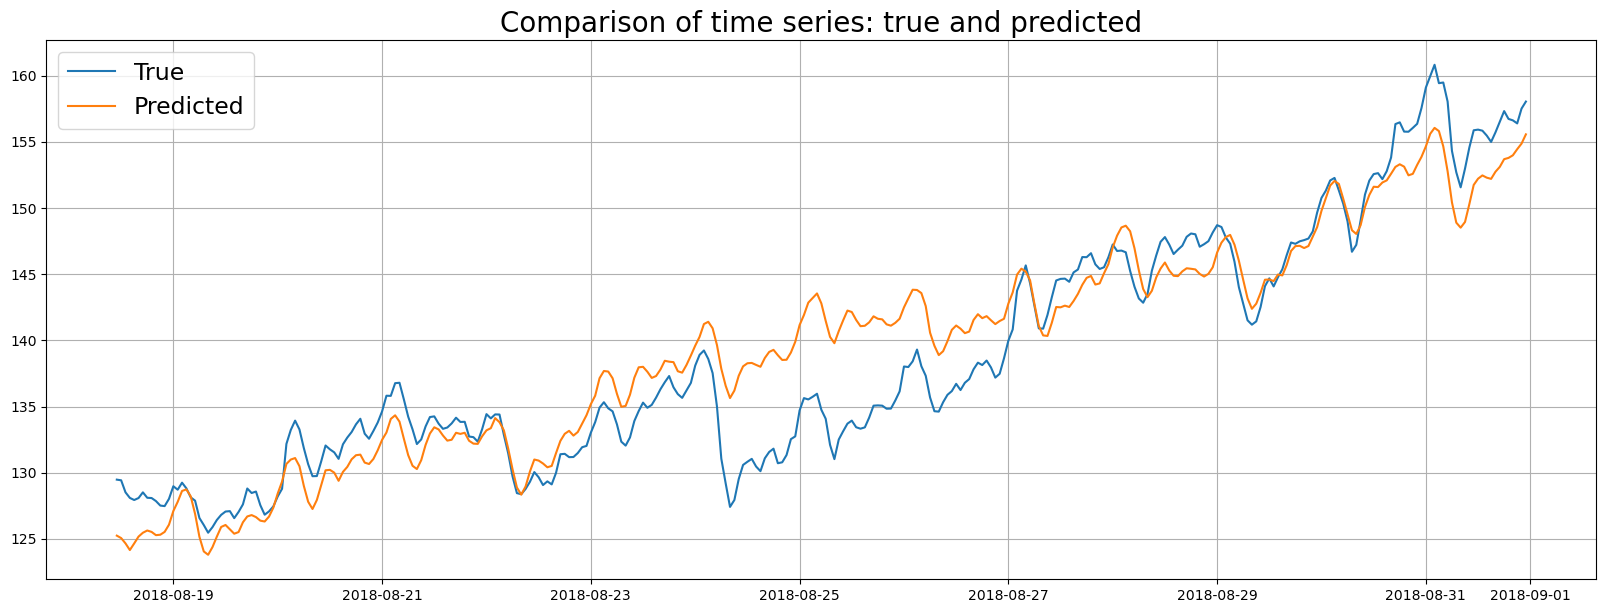

In [42]:
plt.figure(figsize=(20, 7))
plt.title('Comparison of time series: true and predicted', fontsize=20)
plt.grid()
plt.plot(final_data_roolling['True data'])
plt.plot(final_data_roolling['Predicted data'])
plt.legend(['True', 'Predicted'], fontsize=17)
plt.show()

## Общий вывод

Для решения поставленной задачи была проведена работа с полученным датасетом и обучено нескольких моделей для выбора наиболее подоходящей. Основным пунктом в ТЗ идёт получение метрики **RMSE < 48**. По итогу работы можно рекомендовать две модели: дерево и бустинг LGBM. Однако бустинг показывает лучшую метрику, поэтому итоговое тестирование проводилось на нём с результатом **RMSE = 36.63**. 